https://hatespeechdata.com/ is a website describing multiple hate speech datasets available online.
However, for binary classification (hateful / not hateful), msot of them are not suitable for multiple reasons: 



*   The dataset does not contain hate speech data : Instead, it focus on the taxonomy of hate speech (racism, sexism, homophobia etc)
*   The dataset conatins "hate speech / offensive / normal" with a bery high imbalance : only 5% of hate speech for example


The objective of this notebook is to merge multiple hate speech datasets together in order to obtain a balanced and good quality dataset on which we can fine-tune, test and process NLP models.

# README

I use google drive to load the datasets. Please make sure to download the datasets and either adapt your google drive filesystem or find an alternative (but you will have to change the code of the notebook if you choose this)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_DATASETS = '/content/drive/MyDrive/Hate Speech TikTok/datasets'
# Available here https://drive.google.com/drive/folders/1a2wXNLRCroLb6XrAwWa9kUVnJD56Zb2N?usp=sharing 

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import re

# Datasets used

Here we load all the datasets interesting for us : the ones with hate speech and non hate speech. We'll call the datasets either by their names if they exists or by the github author name

## davidson

The dataset contains ~25 000 texts with 5% hate speech

In [ ]:
DATASET = 'davidson'

In [ ]:
import pandas as pd

davidson_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.csv')

In [ ]:
davidson_df.head()
print(f'Size of davidson\'s dataset : {davidson_df.shape}')

Size of davidson's dataset : (24783, 7)


The dataset is divided into hate/offensive/neither
We want to have hate/not hate so we must relabel the dataset and remove useless columns

In [ ]:
# Formatting

# Original dataset classify 0 : Hate speech, 1: Offensive, 2: Neither.
# Here, we classify in terms of hate speech only. 0 if hate speech, 1 if offensive/neither
class_names = ['Hate Speech', 'Offensive or not Hate Speech']

def classify(class_) :
  if class_ == 0 :
    return 0 # Hate speech
  elif class_ == 1 or class_ == 2 :
    return 1 # No hate speech (but may be offensive)

davidson_df['target'] = davidson_df['class'].apply(lambda x: classify(x))

# Rename columns bcs I'm used to it
davidson_df = davidson_df.rename(columns= {'tweet': 'text'})

# Keep only the text and the target columns, we don't care about the rest
davidson_df = davidson_df[['text', 'target']]

davidson_df.head(10)

,text,target
0,!!! RT @mayasolovely: As a woman you shouldn't...,1
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",1
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,1
8,""" &amp; you might not get ya bitch back &amp; ...",1
9,""" @rhythmixx_ :hobbies include: fighting Maria...",1


% of hate speech ?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_imbalance(dataset_df) :
  ax = sns.countplot(dataset_df.target)
  plt.xlabel('review sentiment')
  plt.title('Class Imbalance Diagram')
  ax.set_xticklabels(['Hate Speech', 'Not Hate Speech'])

def get_imbalance(dataset_df) :
  imba_df = dataset_df["target"].value_counts()
  imba_df = imba_df.rename(index= {0 : 'Hate Speech', 1 : 'Not Hate Speech'})
  num_hate = imba_df.loc['Hate Speech']
  num_tot = dataset_df.shape[0]

  return imba_df, 100*num_hate / num_tot

Not Hate Speech    23353
Hate Speech         1430
Name: target, dtype: int64
Frequency of hate speech data : 5.77%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


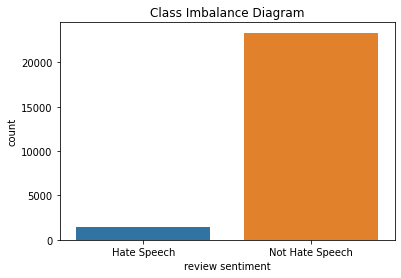

In [ ]:
imba_df, freq_hate = get_imbalance(davidson_df)

plot_bar_imbalance(davidson_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## CONAN

This dataset contains only hate speech (~5000)

In [ ]:
DATASET = 'CONAN'

In [ ]:
conan_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.csv')
print(conan_df.head())
print(f'Size of CONAN dataset : {conan_df.shape}')

   INDEX                                        HATE_SPEECH  ...    TARGET VERSION
0      0  Maybe the UN could talk to those asian and afr...  ...     other      V1
1      1  ‘Juice (Jews) are worse that nukes.’ Caption t...  ...      JEWS      V1
2      2  Foreigners on UK benefits leaps 41% in 5 years...  ...  MIGRANTS      V1
3      3  Jews cannot be patriots, since their allegianc...  ...      JEWS      V1
4      4  Israel, Zionism and Jewish Supremacist control...  ...      JEWS      V1

[5 rows x 5 columns]
Size of CONAN dataset : (5003, 5)


Before concatenating these hate speech, we want to format the dataframe into the correct format with 2 columns (text, target) with target = 0 for hate speech, else 1

Here, all targets must be 0

In [ ]:
conan_df['target'] = 0 # Add column target set to 0 (bcs all texts are hate speech)
conan_df = conan_df[['HATE_SPEECH', 'target']] # Keep the text column only
conan_df = conan_df.rename(columns= {'HATE_SPEECH' : 'text'}) # Rename the text column
conan_df.head()

,text,target
0,Maybe the UN could talk to those asian and afr...,0
1,‘Juice (Jews) are worse that nukes.’ Caption t...,0
2,Foreigners on UK benefits leaps 41% in 5 years...,0
3,"Jews cannot be patriots, since their allegianc...",0
4,"Israel, Zionism and Jewish Supremacist control...",0


Imbalance of data ?

Hate Speech    5003
Name: target, dtype: int64
Frequency of hate speech data : 100.0%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


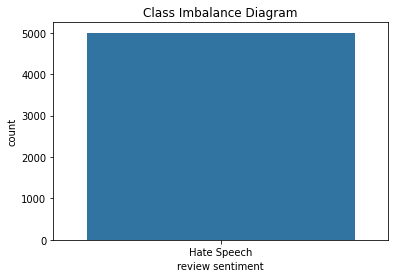

In [ ]:
imba_df, freq_hate = get_imbalance(conan_df)

plot_bar_imbalance(conan_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## HateXplain

This dataset contains ~20 000 data with ~30% of Hate Speech

Also, it contains information on which words are carrying the hate speech which allows training the model for this sub task

In [ ]:
DATASET = 'HateXplain'

In [ ]:
import json
import numpy as np

with open(f'{PATH_DATASETS}/{DATASET}.json', 'r') as fp:
        data = json.load(fp)

hatexplain = []

for post_id in data :
  text_split = data[post_id]['post_tokens'] # = ['example','of','post_tokens']
  text = ' '.join(text_split) # 'example of post_tokens'

  # Now we check what is the label : 3 different anotators so we choose majority voting
  hate_speech_label_occurence = 0
  for i in range(3):
    if data[post_id]['annotators'][i]['label'] == 'hatespeech' : # If the anotator voted 'hatespeech'
      hate_speech_label_occurence += 1
  
  if hate_speech_label_occurence == 2 or hate_speech_label_occurence == 3 : # If the majority voted hate speech
    target = 0
  elif hate_speech_label_occurence == 0 or hate_speech_label_occurence == 1 :
    target = 1

  hatexplain.append([text, target])

hatexplain_df = pd.DataFrame(hatexplain, columns= ['text', 'target'])
print(f'Size of dataset : {hatexplain_df.shape}')

Size of dataset : (20148, 2)


In [ ]:
hatexplain_df.head()

,text,target
0,i dont think im getting my baby them white 9 h...,1
1,we cannot continue calling ourselves feminists...,1
2,nawt yall niggers ignoring me,1
3,<user> i am bit confused coz chinese ppl can n...,0
4,this bitch in whataburger eating a burger with...,0


Imbalance of data ?

Not Hate Speech    14213
Hate Speech         5935
Name: target, dtype: int64
Frequency of hate speech data : 29.46%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


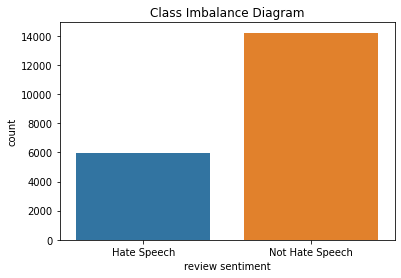

In [ ]:
imba_df, freq_hate = get_imbalance(hatexplain_df)

plot_bar_imbalance(hatexplain_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## hkust

This dataset contains ~5642 texts with ~22% hate speech

In [ ]:
DATASET = 'hkust'

In [ ]:
hkust_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.csv')
hkust_df = hkust_df[['tweet', 'sentiment']]
hkust_df.head()
print(f'This dataset size is : {hkust_df.shape}')

This dataset size is : (5647, 2)


Some tweets are very ugly like :
"@user @user Economic asylum isn\u2019t a thing. Neither is \u201cmy country is a shithole\u201d asylum. \n\nHow m\u2026 @URL"

We clean these tweets :

In [ ]:
import re 

def clean_tweet(tweet) :
  temp = re.sub('\\\\n', '', tweet)
  temp = re.sub('\\\\.....', '', temp)
  temp = re.sub('@URL', '', temp)
  cleaned = re.sub('@user', '', temp)

  return cleaned

In [ ]:
hkust_df['tweet'] = hkust_df['tweet'].apply(clean_tweet)

In [ ]:
hkust_df['tweet'].iloc[21]

'  Economic asylum isnt a thing. Neither is my country is a shithole asylum. How m '

Now we label hateful/not hateful

In [ ]:
def make_target(sentiment) :
  if 'hateful' in sentiment :
    return 0
  else :
    return 1

hkust_df['target'] = hkust_df['sentiment'].apply(make_target)

In [ ]:
hkust_df = hkust_df.rename(columns = {'tweet' : 'text'})
hkust_df = hkust_df[['text', 'target']]
hkust_df.head()

,text,target
0,If America had another 8 years of Obama's ideo...,0
1,Most Canadians have never met seen or associat...,1
2,Hahaha grow up faggot,1
3,queue is fucking retarded it makes everyone f...,0
4,Que ce ne soit pas des Burundais refugies Ale...,0


Data Imbalance ?

Not Hate Speech    4369
Hate Speech        1278
Name: target, dtype: int64
Frequency of hate speech data : 22.63%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


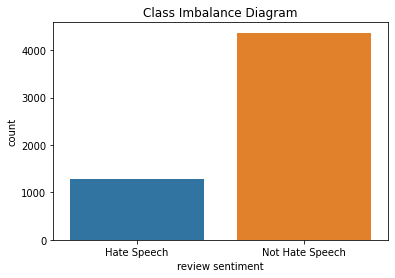

In [ ]:
imba_df, freq_hate = get_imbalance(hkust_df)

plot_bar_imbalance(hkust_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## HASOC 2019

Number of data ~1200 and number of hate speech ~10%

In [ ]:
DATASET = 'HASOC'

In [ ]:
hasoc_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.tsv', sep='\t')

In [ ]:
hasoc_df.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,NOT,NONE,NONE
1,hasoc_en_416,68.5 million people have been forced to leave ...,NOT,NONE,NONE
2,hasoc_en_207,"You came, you saw .... we will look after the ...",NOT,NONE,NONE
3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,NOT,NONE,NONE
4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,HOF,PRFN,UNT


task_2 is the one we want, it labels hate speech, offensive or none

In [ ]:
def make_target(task_2) :
  if task_2 == 'HATE' :
    return 0
  else :
    return 1

hasoc_df['target'] = hasoc_df['task_2'].apply(make_target)

In [ ]:
hasoc_df = hasoc_df[['text', 'target']]

In [ ]:
hasoc_df.head()

,text,target
0,West Bengal Doctor Crisis: Protesting doctors ...,1
1,68.5 million people have been forced to leave ...,1
2,"You came, you saw .... we will look after the ...",1
3,We'll get Brexit delivered by October 31st. ...,1
4,Fuck you. Go back to the dark ages you cow @IB...,1


Data Imbalance ?

Not Hate Speech    1029
Hate Speech         124
Name: target, dtype: int64
Frequency of hate speech data : 10.75%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


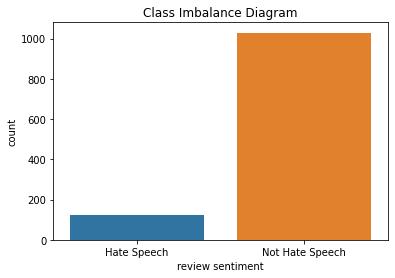

In [ ]:
imba_df, freq_hate = get_imbalance(hasoc_df)

plot_bar_imbalance(hasoc_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## Ethos

Dataset contains ~1000 data with 16% hate speech

In [ ]:
DATASET = 'ethos'

In [ ]:
ethos_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.csv', delimiter=';')

In [ ]:
ethos_df.head()

,comment,isHate
0,You should know women's sports are a joke,1.0
1,You look like Sloth with deeper Down’s syndrome,1.0
2,You look like Russian and speak like Indian. B...,1.0
3,"Women deserve to be abused, I guess.",1.0
4,Women are made for making babies and cooking d...,1.0


In [ ]:
def make_target(isHate) :
  if isHate == 1.0 :
    return 0
  else :
    return 1

ethos_df['target'] = ethos_df['isHate'].apply(make_target)

In [ ]:
ethos_df = ethos_df.rename(columns= {'comment' : 'text'})
ethos_df = ethos_df[['text', 'target']]

Data imbalance ?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Not Hate Speech    835
Hate Speech        163
Name: target, dtype: int64
Frequency of hate speech data : 16.33%


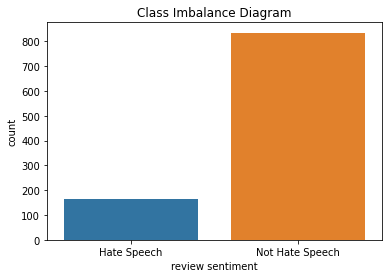

In [ ]:
imba_df, freq_hate = get_imbalance(ethos_df)

plot_bar_imbalance(ethos_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## Kaggle Competition

The dataset contains ~31 000 tweets with ~7% of hate speech

It can be interesting to check the competition's winner... We can also use the test data of the competition as a benchmark

In [ ]:
DATASET = 'kaggle'

In [ ]:
kaggle_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.csv')

In [ ]:
def make_target(label) :
  if label == 0 :
    return 1
  else :
    return 0

kaggle_df['target'] = kaggle_df['label'].apply(make_target)

In [ ]:
kaggle_df = kaggle_df.rename(columns= {'tweet' : 'text'})
kaggle_df = kaggle_df[['text', 'target']]

Data Imbblance ?

Not Hate Speech    29720
Hate Speech         2242
Name: target, dtype: int64
Frequency of hate speech data : 7.01%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


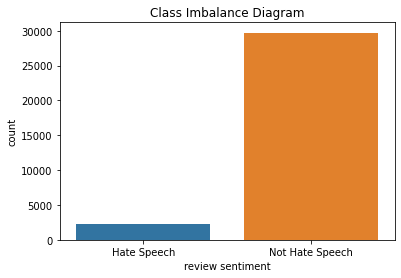

In [ ]:
imba_df, freq_hate = get_imbalance(kaggle_df)

plot_bar_imbalance(kaggle_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

## ICWSM18 dataset

This dataset contains ~3200 comments with ~75% of hate speech

In [ ]:
DATASET = 'ICWSM18'

In [ ]:
icwsm18_df = pd.read_excel(f'{PATH_DATASETS}/{DATASET}.xlsx')

In [ ]:
icwsm18_df.head()

,ID,title,type,message,Class,Sub 1,Sub 2,Sub 3,Sub 4,Sub 5
0,22838,Virginia Police Pepper-Sprayed A Man Having A ...,video,this is disgusting and heartbreaking. they sho...,Hateful,Towards law enforcement,NaN,NaN,NaN,NaN
1,53074,Delaware Police Officer Re-Indicted For Brutal...,video,Fuck that cop. Nothing but a fucking thug. \n\...,Hateful,Towards law enforcement,NaN,NaN,NaN,NaN
2,85387,Laquan McDonald Murder Covered Up By Chicago P...,video,"Fucking piece of shit cops, protect and serve ...",Hateful,Towards law enforcement,NaN,NaN,NaN,NaN
3,92351,Alabama Police Paralyze Grandfather From India...,video,Land of the free... My fucking ass. America is...,Hateful,Towards law enforcement,Accusations,NaN,NaN,NaN
4,96952,Man Killed By Taser,video,These fucking cops are out of control!,Hateful,Towards law enforcement,NaN,NaN,NaN,NaN


In [ ]:
def make_target(class_) :
  if class_ == 'Hateful' :
    return 0
  else :
    return 1

icwsm18_df['target'] = icwsm18_df['Class'].apply(make_target)

In [ ]:
icwsm18_df = icwsm18_df.rename(columns= {'message' : 'text'})
icwsm18_df = icwsm18_df[['text', 'target']]

Class imbalance ?

Hate Speech        2364
Not Hate Speech     858
Name: target, dtype: int64
Frequency of hate speech data : 73.37%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


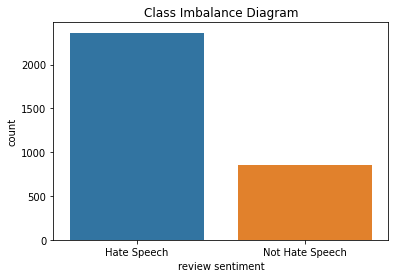

In [ ]:
imba_df, freq_hate = get_imbalance(icwsm18_df)

plot_bar_imbalance(icwsm18_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

# Concatenation

In [ ]:
merged_df = pd.concat([davidson_df, conan_df, hatexplain_df, hkust_df, hasoc_df, ethos_df, kaggle_df, icwsm18_df])
print(f'Total size of merged dataset : {merged_df.shape}')

Total size of merged dataset : (92916, 2)


Not Hate Speech    74377
Hate Speech        18539
Name: target, dtype: int64
Frequency of hate speech data : 19.95%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


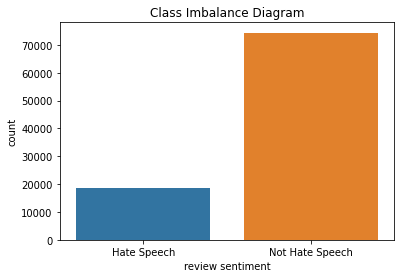

In [ ]:
imba_df, freq_hate = get_imbalance(merged_df)

plot_bar_imbalance(merged_df)
print(imba_df)
print(f'Frequency of hate speech data : {round(freq_hate,2)}%')

Save merged dataset into csv

In [ ]:
DATASET = 'merged'
merged_df.to_csv(f'{PATH_DATASETS}/{DATASET}.csv')